In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gaitFunctions

# Coordination consistency score
This is a per-tardigrade score
= swings in tetrapod / total swings (for each leg or all legs)

In [2]:
# From all tardigrade spreadsheet (all_exemplaris_2024-07-29.xlsx, gait_speeds sheet):
#     get gait_speeds_df
#     get gait_summaries_df
excel_file = 'all_exemplaris_2024-07-29.xlsx'
gait_speeds_df = pd.read_excel(excel_file, sheet_name = 'gait_speeds', index_col=None)
gait_summaries_df = pd.read_excel(excel_file, sheet_name = 'gait_summaries', index_col=None)
print(gait_speeds_df.columns)
gait_speeds_df.head(2)

Index(['frametimes', 'speed (mm/s)', 'speed (bodylength/s)', 'gaits_lateral',
       'swinging_lateral', 'gaits_rear', 'swinging_rear',
       'tetrapod_coordination', 'tetrapod_speed', 'tripod_coordination',
       'tripod_speed', 'clip', 'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')


,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed,clip,treatment,individual,date,uniq_id
0,0.0303,0.081255,0.331912,tetrapod_canonical,L3_R1,step,R4,0.545455,0.354355,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,0.0606,0.083660,0.341737,tetrapod_canonical,L3_R1,hop,L4_R4,NaN,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


In [3]:
def coordinationConsistency(gait_speeds_df, gait_summaries_df, icp):  # 'tetrapod' or 'tripod'
    
    coord_consistency_dict = {}
    legs = ['L3','L2','L1','R3','R2','R1']
    individuals = np.unique(gait_speeds_df['uniq_id'].values)
    # print(len(individuals)) # testing OK

    icp_searchterm = icp + '_canonical'

    # For each individual
    for individual in individuals:

        # make df for this individual from gait_speeds_df
        ind_df = gait_speeds_df[gait_speeds_df['uniq_id']==individual]
        # print(len(ind_df)) # testing OK

        total_swings = 0
        swings_with_icp = 0

        swinging_legs = ind_df['swinging_lateral'].values
        icps = ind_df['gaits_lateral'].values
        # print(swinging_legs) # testing OK

        # For each leg
        for leg in legs:

            # make vector of 1's (swings for this leg) and 0's from swinging_lateral column
            swings_for_this_leg = np.zeros(len(swinging_legs))
            for i, swing in enumerate(swinging_legs):
                try:
                    if leg in swing:
                        swings_for_this_leg[i] = 1
                except:
                    swings_for_this_leg[i] = 0

            # print(leg, swings_for_this_leg) # testing OK

            # From this vector, get num_swings (aka number of 1 runs)
            swings = gaitFunctions.one_runs(swings_for_this_leg)
            # print(leg, len(swings), swings) # testing OK

            total_swings += len(swings)

            # For each swing
            for swing in swings:
                # get each swing start through swing end
                swing_start = swing[0]
                swing_end = swing[1]

                # Check vector of gaits_lateral within this interval ... is there tetrapod_canonical?
                if icp_searchterm in icps[swing_start:swing_end]:
                    # print(icp_searchterm, icps[swing_start:swing_end]) # testing OK
                    # if yes, add 1 to swings_with_icp
                    swings_with_icp += 1

        # Finished collecting legs for this invididual
        # Calculate coord_consistency (swings_with_icp / total_swings)
        coord_consistency = swings_with_icp / total_swings
        # print(individual, coord_consistency) # testing OK
        coord_consistency_dict[individual] = coord_consistency
    
    # add this dictionary as a column to gait_summaries df
    new_df = gait_summaries_df.copy()
    new_individuals = new_df.Identifier.values
    cc = [coord_consistency_dict[i] for i in new_individuals]
    # print(cc) # testing OK
    new_df[icp + '_coordination_consistency'] = cc
    
    return new_df

gait_summaries_df = coordinationConsistency(gait_speeds_df, gait_summaries_df, 'tetrapod')
# gait_summaries_df.head(3)

# then do some paired comparisons:
# • speed vs. coord_consistency
# • % tetrapod_canonical vs. coord_consistency
# • coordination strength score vs. coord_consistency

# Or better, a correlation matrix including:
#     speed
#     coordination %
#     coordination strength
#     coordination consistency

In [4]:
print(gait_summaries_df.columns)
gait_summaries_df.head(3)

Index(['Identifier', 'treatment', 'individual', 'date', 'Number of frames',
       '% stand (lateral legs)', '% pentapod (lateral legs)',
       '% tetrapod canonical (lateral legs)',
       '% tetrapod gallop (lateral legs)', '% tetrapod other (lateral legs)',
       '% tetrapod total (lateral legs)', '% tripod canonical (lateral legs)',
       '% tripod other (lateral legs)', '% tripod total (lateral legs',
       '% other (lateral legs)', '% stand (rear legs)', '% hop (rear legs)',
       '% step (rear legs)', 'Tetrapod Coordination Strength',
       'Tetrapod Bout Speed (bodylength / s)', 'Tripod Coordination Strength',
       'Tripod Bout Speed (bodylength / s)', 'CLR stand (lateral legs)',
       'CLR pentapod (lateral legs)', 'CLR tetrapod canonical (lateral legs)',
       'CLR tetrapod gallop (lateral legs)',
       'CLR tetrapod other (lateral legs)',
       'CLR tripod canonical (lateral legs)',
       'CLR tripod other (lateral legs)', 'CLR other (lateral legs)',
       'CLR

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs),tetrapod_coordination_consistency
0,iw_21dec_tardigrade01_exemplaris,exemplaris,tardigrade01,21dec,526,4.942966,33.460076,48.859316,5.323194,1.711027,...,0.169186,0.809203,-0.586456,0.057069,-0.374970,1.131811,-0.551917,0.046303,0.679482,0.909091
1,iw_21dec_tardigrade02_exemplaris,exemplaris,tardigrade02,21dec,550,4.363636,32.545455,53.090909,6.000000,0.909091,...,0.252247,0.928889,-1.218860,-6.463120,-0.294424,-2.725511,0.191923,0.008375,0.582679,0.936000
2,iw_21dec_tardigrade03_exemplaris,exemplaris,tardigrade03,21dec,612,10.947712,43.137255,28.267974,11.111111,2.614379,...,-0.378029,1.545075,-0.162523,-2.733419,-0.098957,-2.725511,0.604985,0.014889,-0.023126,0.694215


In [5]:
interesting_df = gait_summaries_df[['% tetrapod canonical (lateral legs)',
                                   'Tetrapod Coordination Strength',
                                   'Tetrapod Bout Speed (bodylength / s)',
                                   'tetrapod_coordination_consistency']]
interesting_df.head(3)

,% tetrapod canonical (lateral legs),Tetrapod Coordination Strength,Tetrapod Bout Speed (bodylength / s),tetrapod_coordination_consistency
0,48.859316,0.381904,0.298387,0.909091
1,53.090909,0.402442,0.307859,0.936000
2,28.267974,0.425673,0.262655,0.694215


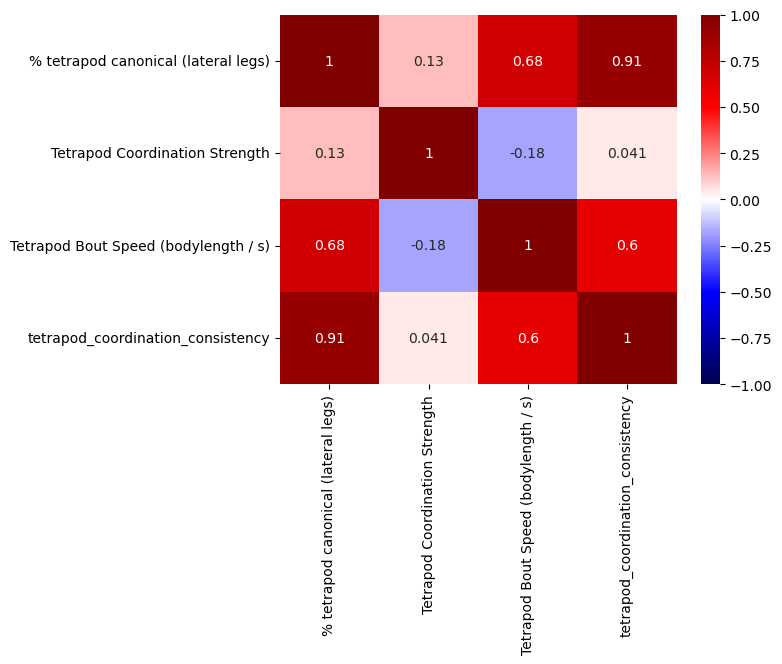

"\nsuper high correlation between 'consistency' and % tetrapod ... which makes sense.\nhigher % overall = higher % of steps that are tetrapod\n"

In [8]:
import seaborn as sns
ax = sns.heatmap(interesting_df.corr(), annot=True, cmap="seismic", vmin = -1, vmax = 1)
plt.show()
'''
super high correlation between 'consistency' and % tetrapod ... which makes sense.
higher % overall = higher % of steps that are tetrapod
'''

In [9]:
''' 
try a different way, more about 'consistency'
within each clip
each leg
    get all tetrapod (or tripod) combos for this leg
    get all gait_styles during swings of this leg
    find out which tetrapod combo is most prevalent
    num_steps_with_combo += these
    total_steps += these
'''
excel_file = 'all_exemplaris_2024-07-29.xlsx'
gait_speeds_df = pd.read_excel(excel_file, sheet_name = 'gait_speeds', index_col=None)
gait_summaries_df = pd.read_excel(excel_file, sheet_name = 'gait_summaries', index_col=None)
print(gait_speeds_df.columns)
gait_speeds_df.head(2)

Index(['frametimes', 'speed (mm/s)', 'speed (bodylength/s)', 'gaits_lateral',
       'swinging_lateral', 'gaits_rear', 'swinging_rear',
       'tetrapod_coordination', 'tetrapod_speed', 'tripod_coordination',
       'tripod_speed', 'clip', 'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')


,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed,clip,treatment,individual,date,uniq_id
0,0.0303,0.081255,0.331912,tetrapod_canonical,L3_R1,step,R4,0.545455,0.354355,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,0.0606,0.083660,0.341737,tetrapod_canonical,L3_R1,hop,L4_R4,NaN,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


In [12]:
def canonicalComboList(icp):
    if icp == 'tripod':
        return ['L1_L3_R2','L2_R1_R3']
    else:
        return ['L1_R2','L1_R3','L2_R1','L2_R3','L3_R1','L3_R2']

def combosWithLeg(leg, icp):
    '''
    make dictionary of tetrapod and tripod tripod combos
    key = leg; value = combo for that leg
    '''
    # could code these but too lazy
    tetrapod = {}
    tetrapod['L1'] = ['L1_R2','L1_R3']
    tetrapod['L2'] = ['L2_R1','L2_R3']
    tetrapod['L3'] = ['L3_R1','L3_R2']
    tetrapod['R1'] = ['L2_R1','L3_R1']
    tetrapod['R2'] = ['L1_R2','L3_R2']
    tetrapod['R3'] = ['L1_R3','L2_R3']
    
    tripod = {}
    tripod['L1'] = ['L1_L3_R2']
    tripod['L2'] = ['L2_R1_R3']
    tripod['L3'] = ['L1_L3_R2']
    tripod['R1'] = ['L2_R1_R3']
    tripod['R2'] = ['L1_L3_R2']
    tripod['R3'] = ['L2_R1_R3']
    
    if icp == 'tripod':
        return tripod[leg]
    else:
        return tetrapod[leg]
    
def coordinationComboConsistency(gait_speeds_df, gait_summaries_df, icp):  # 'tetrapod' or 'tripod'
    
    coord_consistency_dict = {}
    legs = ['L3','L2','L1','R3','R2','R1']
    individuals = np.unique(gait_speeds_df['uniq_id'].values)
    # print(len(individuals)) # testing OK

    icp_searchterm = icp + '_canonical'
    
    icp_combos = canonicalComboList(icp)
    # print(icp_combos) # testing OK

    # For each individual
    for individual in individuals:

        # reset counts
        total_swings = 0
        swings_with_icp = 0
        
        # make df for this individual from gait_speeds_df
        ind_df = gait_speeds_df[gait_speeds_df['uniq_id']==individual]
        # print(len(ind_df)) # testing OK

        # get clips for this individual
        clips = np.unique(ind_df['clip'].values)
        # print(clips) # testing OK
        
        # for each clip
        for clip in clips:
            
            clip_df = ind_df[ind_df['clip']==clip]
            # print(len(clip_df)) # testing OK
        
            # find counts for canonical leg combos in this clip
            swinging_legs = clip_df['swinging_lateral'].values
            # print(swinging_legs) # testing OK
            combo_counts = {}            
            for combo in icp_combos:
                combo_counts[combo] = len(np.where(swinging_legs == combo)[0])
            # print(clip, combo_counts) # testing OK

            # for each leg, get # of swings
            
            # figure out how many steps for this leg have the most prevalent combo
            for leg in legs:

                # get the icp combos for this leg
                leg_combos = combosWithLeg(leg, icp)
                
                # figure out which combo is most prevalent for this leg
                counter = 0
                for leg_combo in leg_combos:
                    if combo_counts[leg_combo] > counter:
                        common_icp = leg_combo
                        counter = combo_counts[leg_combo]
                # print(leg, common_icp) # testing OK

                # make vector of 1's (swings for this leg) and 0's from swinging_lateral column
                swings_for_this_leg = np.zeros(len(swinging_legs))
                for i, swing in enumerate(swinging_legs):
                    try:
                        if leg in swing:
                            swings_for_this_leg[i] = 1
                    except:
                        swings_for_this_leg[i] = 0
                # print(leg, swings_for_this_leg) # testing OK

                # From this vector, get num_swings (aka number of 1 runs)
                swings = gaitFunctions.one_runs(swings_for_this_leg)
                #print(leg, len(swings), swings) # testing OK
                total_swings += len(swings)

                # For each swing
                for swing in swings:
                    # get each swing start through swing end
                    swing_start = swing[0]
                    swing_end = swing[1]

                    # Check vector of swinging_legs within this interval ... is common_icp in there?
                    if common_icp in swinging_legs[swing_start:swing_end]:
                        # print(leg,'yes',common_icp, swinging_legs[swing_start:swing_end]) # testing OK
                        # if yes, add 1 to swings_with_icp
                        swings_with_icp += 1
                    # else:
                        # print(leg,'no',common_icp, swinging_legs[swing_start:swing_end]) # testing OK

        # Finished collecting legs for this individual
        # Calculate coord_consistency (swings_with_icp / total_swings)
        coord_consistency = swings_with_icp / total_swings
        # print(individual, coord_consistency) # testing OK
        coord_consistency_dict[individual] = coord_consistency
    
    # add this dictionary as a column to gait_summaries df
    new_df = gait_summaries_df.copy()
    new_individuals = new_df.Identifier.values
    cc = [coord_consistency_dict[i] for i in new_individuals]
    # print(cc) # testing OK
    new_df[icp + '_coordination_consistency'] = cc
    
    return new_df

ndf = coordinationComboConsistency(gait_speeds_df, gait_summaries_df, 'tetrapod')


In [13]:
new_interesting_df = ndf[['% tetrapod canonical (lateral legs)',
                                   'Tetrapod Coordination Strength',
                                   'Tetrapod Bout Speed (bodylength / s)',
                                   'tetrapod_coordination_consistency']]
new_interesting_df.head(3)

,% tetrapod canonical (lateral legs),Tetrapod Coordination Strength,Tetrapod Bout Speed (bodylength / s),tetrapod_coordination_consistency
0,48.859316,0.381904,0.298387,0.793388
1,53.090909,0.402442,0.307859,0.816000
2,28.267974,0.425673,0.262655,0.500000


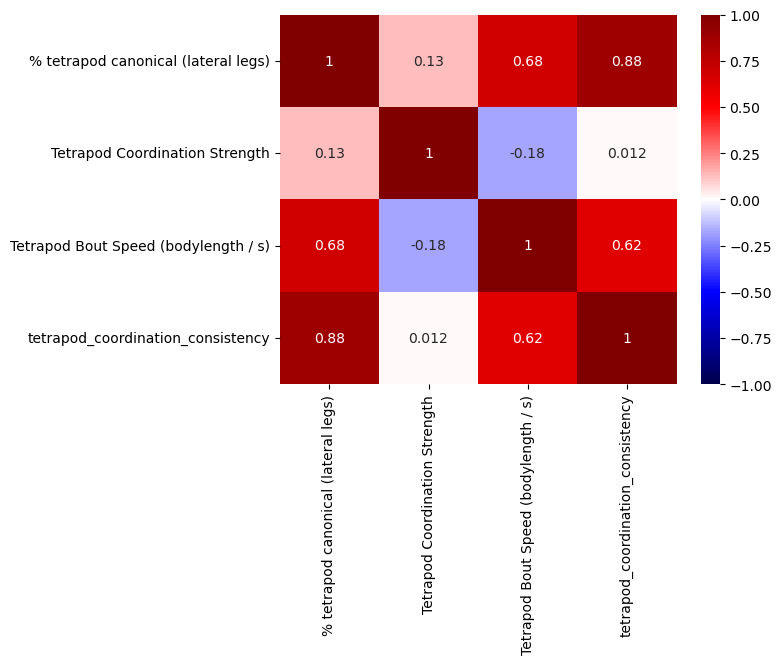

In [15]:
ax = sns.heatmap(new_interesting_df.corr(), annot=True, cmap="seismic", vmax=1, vmin=-1)
plt.show()

Very high correlation between 'combo consistency' and % tetrapod
<br> High correlation between bout speed and combo consistency and % tetrapod
<br> BUT coordination strength is not correlated to any of the other measurements


# Coordination strength score

In July 2024, Made CSS robust to changes in identities of swinging legs<br>
<br>
For example: <br>
L1R2 → L3R2 with a seamless transition is now one bout of tetrapod_canonical rather than two

Exported code to analyzeSteps.py on 29 July 2024 (this code in analyzeSteps is likely updated and more current now)
<br>
<br>
But from above, coordination strength score (CSS) is not correlated to any of the other measures of coordination.
<br> This is a bit concerning ... need to check that I am assigning correct CSS to correct individuals.

<br><br>To double check, start with gait_styles sheet, and reassign CSS (and bout speed) to individuals.
<br><br>Update = same answers

In [16]:
excel_file = 'all_exemplaris_2024-07-29.xlsx'
gait_speeds_df = pd.read_excel(excel_file, sheet_name = 'gait_speeds', index_col=None)
gait_summaries_df = pd.read_excel(excel_file, sheet_name = 'gait_summaries', index_col=None)
print(gait_speeds_df.columns)
gait_speeds_df.head(2)

Index(['frametimes', 'speed (mm/s)', 'speed (bodylength/s)', 'gaits_lateral',
       'swinging_lateral', 'gaits_rear', 'swinging_rear',
       'tetrapod_coordination', 'tetrapod_speed', 'tripod_coordination',
       'tripod_speed', 'clip', 'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')


,frametimes,speed (mm/s),speed (bodylength/s),gaits_lateral,swinging_lateral,gaits_rear,swinging_rear,tetrapod_coordination,tetrapod_speed,tripod_coordination,tripod_speed,clip,treatment,individual,date,uniq_id
0,0.0303,0.081255,0.331912,tetrapod_canonical,L3_R1,step,R4,0.545455,0.354355,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris
1,0.0606,0.083660,0.341737,tetrapod_canonical,L3_R1,hop,L4_R4,NaN,NaN,NaN,NaN,iw_21Dec_exemplaris_tardigrade01_064-072,exemplaris,1,21dec,iw_21dec_tardigrade01_exemplaris


In [24]:
def reassignCSS(gait_speeds_df, gait_summaries_df):
    new_summaries_df = gait_summaries_df.copy()
    
    individuals = np.unique(gait_speeds_df['uniq_id'].values)
    css = {}
    boutspeed = {}

    for individual in individuals:
        ind_df = gait_speeds_df[gait_speeds_df['uniq_id']==individual]
        avg_css = np.nanmean(ind_df['tetrapod_coordination'].values)
        avg_boutspeed = np.nanmean(ind_df['tetrapod_speed'].values)
        css[individual] = avg_css
        boutspeed[individual] = avg_boutspeed
        
    summaries_individuals = new_summaries_df.Identifier.values
    updated_css = [css[individual] for individual in summaries_individuals]
    updated_boutspeed = [boutspeed[individual] for individual in summaries_individuals]
    
    new_summaries_df['tetrapod_coordination'] = updated_css
    new_summaries_df['tetrapod_speed'] = updated_boutspeed
    
    return new_summaries_df

In [25]:
ndf = reassignCSS(gait_speeds_df, gait_summaries_df)
ndf.head(3)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs),tetrapod_coordination,tetrapod_speed
0,iw_21dec_tardigrade01_exemplaris,exemplaris,tardigrade01,21dec,526,4.942966,33.460076,48.859316,5.323194,1.711027,...,0.809203,-0.586456,0.057069,-0.374970,1.131811,-0.551917,0.046303,0.679482,0.381904,0.298387
1,iw_21dec_tardigrade02_exemplaris,exemplaris,tardigrade02,21dec,550,4.363636,32.545455,53.090909,6.000000,0.909091,...,0.928889,-1.218860,-6.463120,-0.294424,-2.725511,0.191923,0.008375,0.582679,0.402442,0.307859
2,iw_21dec_tardigrade03_exemplaris,exemplaris,tardigrade03,21dec,612,10.947712,43.137255,28.267974,11.111111,2.614379,...,1.545075,-0.162523,-2.733419,-0.098957,-2.725511,0.604985,0.014889,-0.023126,0.425673,0.262655


In [26]:
ndf_consistency = coordinationComboConsistency(gait_speeds_df, ndf, 'tetrapod')
ndf_consistency.head(3)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs),tetrapod_coordination,tetrapod_speed,tetrapod_coordination_consistency
0,iw_21dec_tardigrade01_exemplaris,exemplaris,tardigrade01,21dec,526,4.942966,33.460076,48.859316,5.323194,1.711027,...,-0.586456,0.057069,-0.374970,1.131811,-0.551917,0.046303,0.679482,0.381904,0.298387,0.793388
1,iw_21dec_tardigrade02_exemplaris,exemplaris,tardigrade02,21dec,550,4.363636,32.545455,53.090909,6.000000,0.909091,...,-1.218860,-6.463120,-0.294424,-2.725511,0.191923,0.008375,0.582679,0.402442,0.307859,0.816000
2,iw_21dec_tardigrade03_exemplaris,exemplaris,tardigrade03,21dec,612,10.947712,43.137255,28.267974,11.111111,2.614379,...,-0.162523,-2.733419,-0.098957,-2.725511,0.604985,0.014889,-0.023126,0.425673,0.262655,0.500000


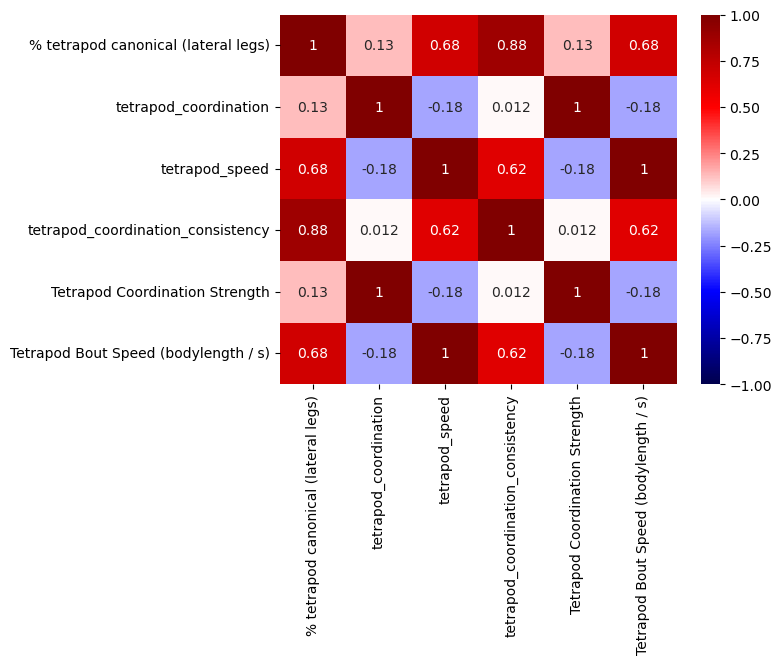

In [29]:
ndf_interesting_new = ndf_consistency[['% tetrapod canonical (lateral legs)',
                                   'tetrapod_coordination',
                                   'tetrapod_speed',
                                   'tetrapod_coordination_consistency',
                                   'Tetrapod Coordination Strength',
                                   'Tetrapod Bout Speed (bodylength / s)']]

ax = sns.heatmap(ndf_interesting_new.corr(), annot=True, cmap="seismic", vmax=1, vmin=-1)
plt.show()